1. Predictive Charging Behavior
2. Optimizing Charging Efficiency
3. State of Charge Management
4. User Behavior Profiling
5. Temperature Influence on Charging Patterns
6. Charging Cost Optimization
7. Distance Prediction Post-Charge

In [41]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('ev_charging_patterns.csv')
data.head()

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


In [5]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

,Battery Capacity (kWh),Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years)
count,1320.000000,1254.000000,1320.000000,1254.000000,1320.000000,1320.000000,1320.000000,1254.000000,1320.000000,1320.000000
mean,74.534692,42.642894,2.269377,25.963003,22.551352,49.130012,75.141590,153.596788,15.263591,3.612843
std,20.626914,22.411705,1.061037,14.011326,10.751494,24.074134,17.080580,86.004987,14.831216,2.309824
min,1.532807,0.045772,0.095314,1.472549,0.234317,2.325959,7.604224,0.862361,-10.724770,0.000000
25%,62.000000,23.881193,1.397623,13.856583,13.368141,27.786903,62.053266,79.445335,2.800664,2.000000
50%,75.000000,42.691405,2.258136,25.603799,22.076360,48.241771,75.682496,152.259867,14.630846,4.000000
75%,85.000000,61.206218,3.112806,37.502998,31.646044,69.277921,88.201370,226.073284,27.981810,6.000000
max,193.003074,152.238758,7.635145,97.342255,69.407743,152.489761,177.708666,398.364775,73.169588,11.688592


### Handling missing values ###

In [8]:
# Check for missing values in the dataset
print('Missing values before imputation:\n', data.isnull().sum())

# Impute missing values using the mean for continuous numeric columns
data['Energy Consumed (kWh)'].fillna(data['Energy Consumed (kWh)'].mean())
data['Charging Rate (kW)'].fillna(data['Charging Rate (kW)'].mean())
data['Distance Driven (since last charge) (km)'].fillna(data['Distance Driven (since last charge) (km)'].mean())

# Check again to ensure all missing values have been handled
print('\nMissing values after imputation:\n', data.isnull().sum())

# save the cleaned dataset
data.to_csv('cleaned_ev_charging_patterns.csv')

data = pd.read_csv('cleaned_ev_charging_patterns.csv')

Missing values before imputation:
 User ID                                      0
Vehicle Model                                0
Battery Capacity (kWh)                       0
Charging Station ID                          0
Charging Station Location                    0
Charging Start Time                          0
Charging End Time                            0
Energy Consumed (kWh)                       66
Charging Duration (hours)                    0
Charging Rate (kW)                          66
Charging Cost (USD)                          0
Time of Day                                  0
Day of Week                                  0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (km)    66
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
User Type                                    0
dtype: int64

Missing val

### Feature Engineering ###

In [45]:
# Convert time to datetime format
data['Charging Start Time'] = pd.to_datetime(data['Charging Start Time'])
data['Charging End Time'] = pd.to_datetime(data['Charging End Time'])

# Feature 1: Extract the time features
data['Hour of Day'] = data['Charging Start Time'].dt.hour
data['Start Day'] = data['Charging Start Time'].dt.day
data['Start Month'] = data['Charging Start Time'].dt.month
data['Start Weekday'] = data['Charging Start Time'].dt.weekday  # 0=Monday, 6=Sunday
data['Is Weekend'] = data['Start Weekday'] >= 5

# Feature 2: Create 'Charging Efficiency (kWh/hour)' as Energy Consumed divided by Charging Duration
data['Charging Efficiency (kWh/hour)'] = data['Energy Consumed (kWh)'] / data['Charging Duration (hours)']

# Feature 3: Create 'State of Charge Delta (%)' as the difference between End and Start percentages
data['State of Charge Delta (%)'] = data['State of Charge (End %)'] - data['State of Charge (Start %)']

# Create a new feature to flag if charging occurred between 80% and 100%
data['Charging 80-100%'] = ((data['State of Charge (Start %)'] < 100) & (data['State of Charge (End %)'] > 80)).astype(int)

# Check the new features in the dataset
data[['Hour of Day', 'Charging Efficiency (kWh/hour)', 'State of Charge Delta (%)', 'State of Charge (End %)', 'Charging 80-100%']].head()

,Hour of Day,Charging Efficiency (kWh/hour),State of Charge Delta (%),State of Charge (End %),Charging 80-100%
0,0,102.665033,56.748386,86.119962,1
1,1,3.937666,74.548566,84.664344,1
2,2,7.799260,63.063011,69.917615,0
3,3,62.741544,16.504325,99.624328,1
4,4,9.718509,9.484836,63.743786,0


In [47]:
data.head()

,Unnamed: 0,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),...,User Type,Hour of Day,Start Day,Start Month,Start Weekday,Is Weekend,Charging Efficiency (kWh/hour),State of Charge Delta (%),Charge Added (%),Charging 80-100%
0,0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,...,Commuter,0,1,1,0,False,102.665033,56.748386,56.748386,1
1,1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,...,Casual Driver,1,1,1,0,False,3.937666,74.548566,74.548566,1
2,2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,...,Commuter,2,1,1,0,False,7.799260,63.063011,63.063011,0
3,3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,...,Long-Distance Traveler,3,1,1,0,False,62.741544,16.504325,16.504325,1
4,4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,...,Long-Distance Traveler,4,1,1,0,False,9.718509,9.484836,9.484836,0


### Data Correlation ###

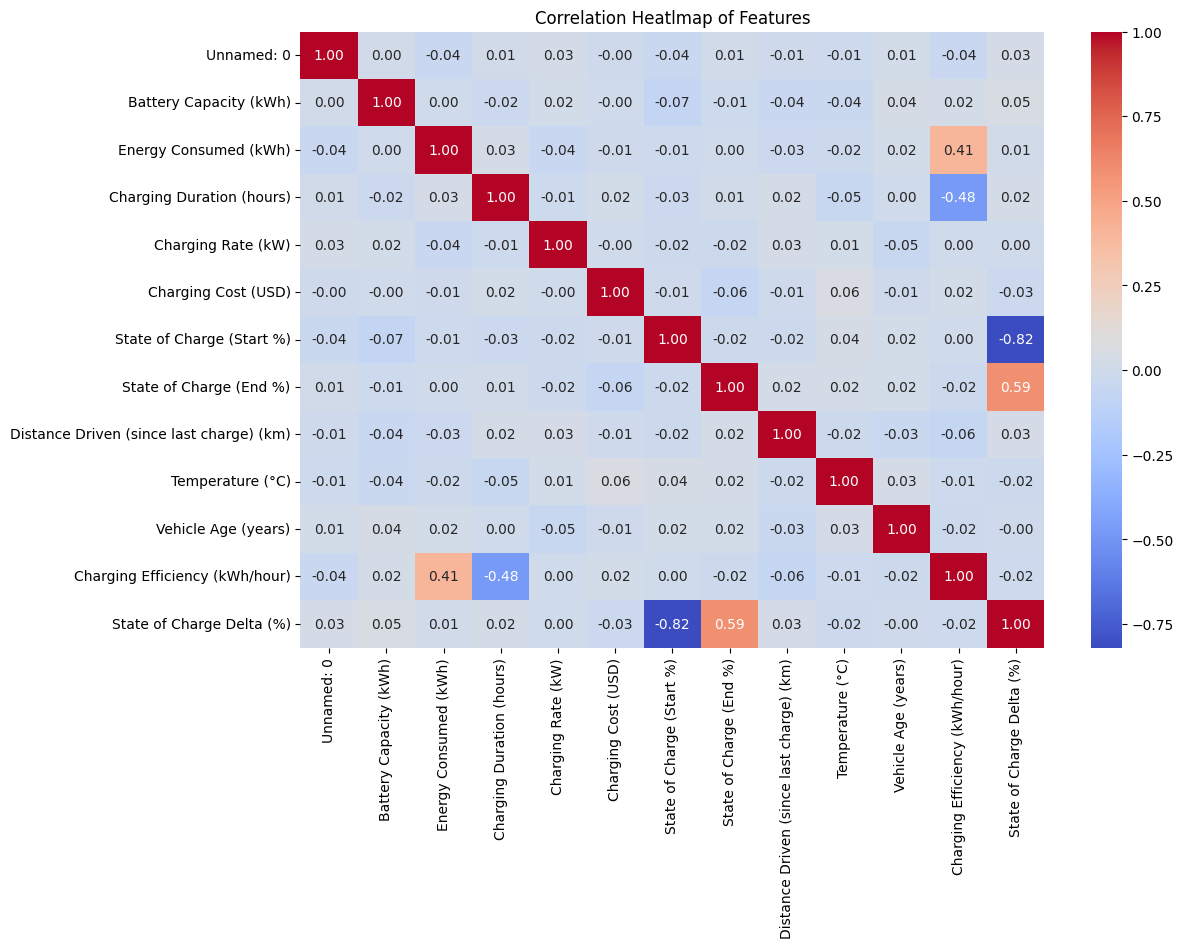

In [57]:
# Plot the correltion heatmap
# Select only numeric columns for correlation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatlmap of Features")
plt.show()

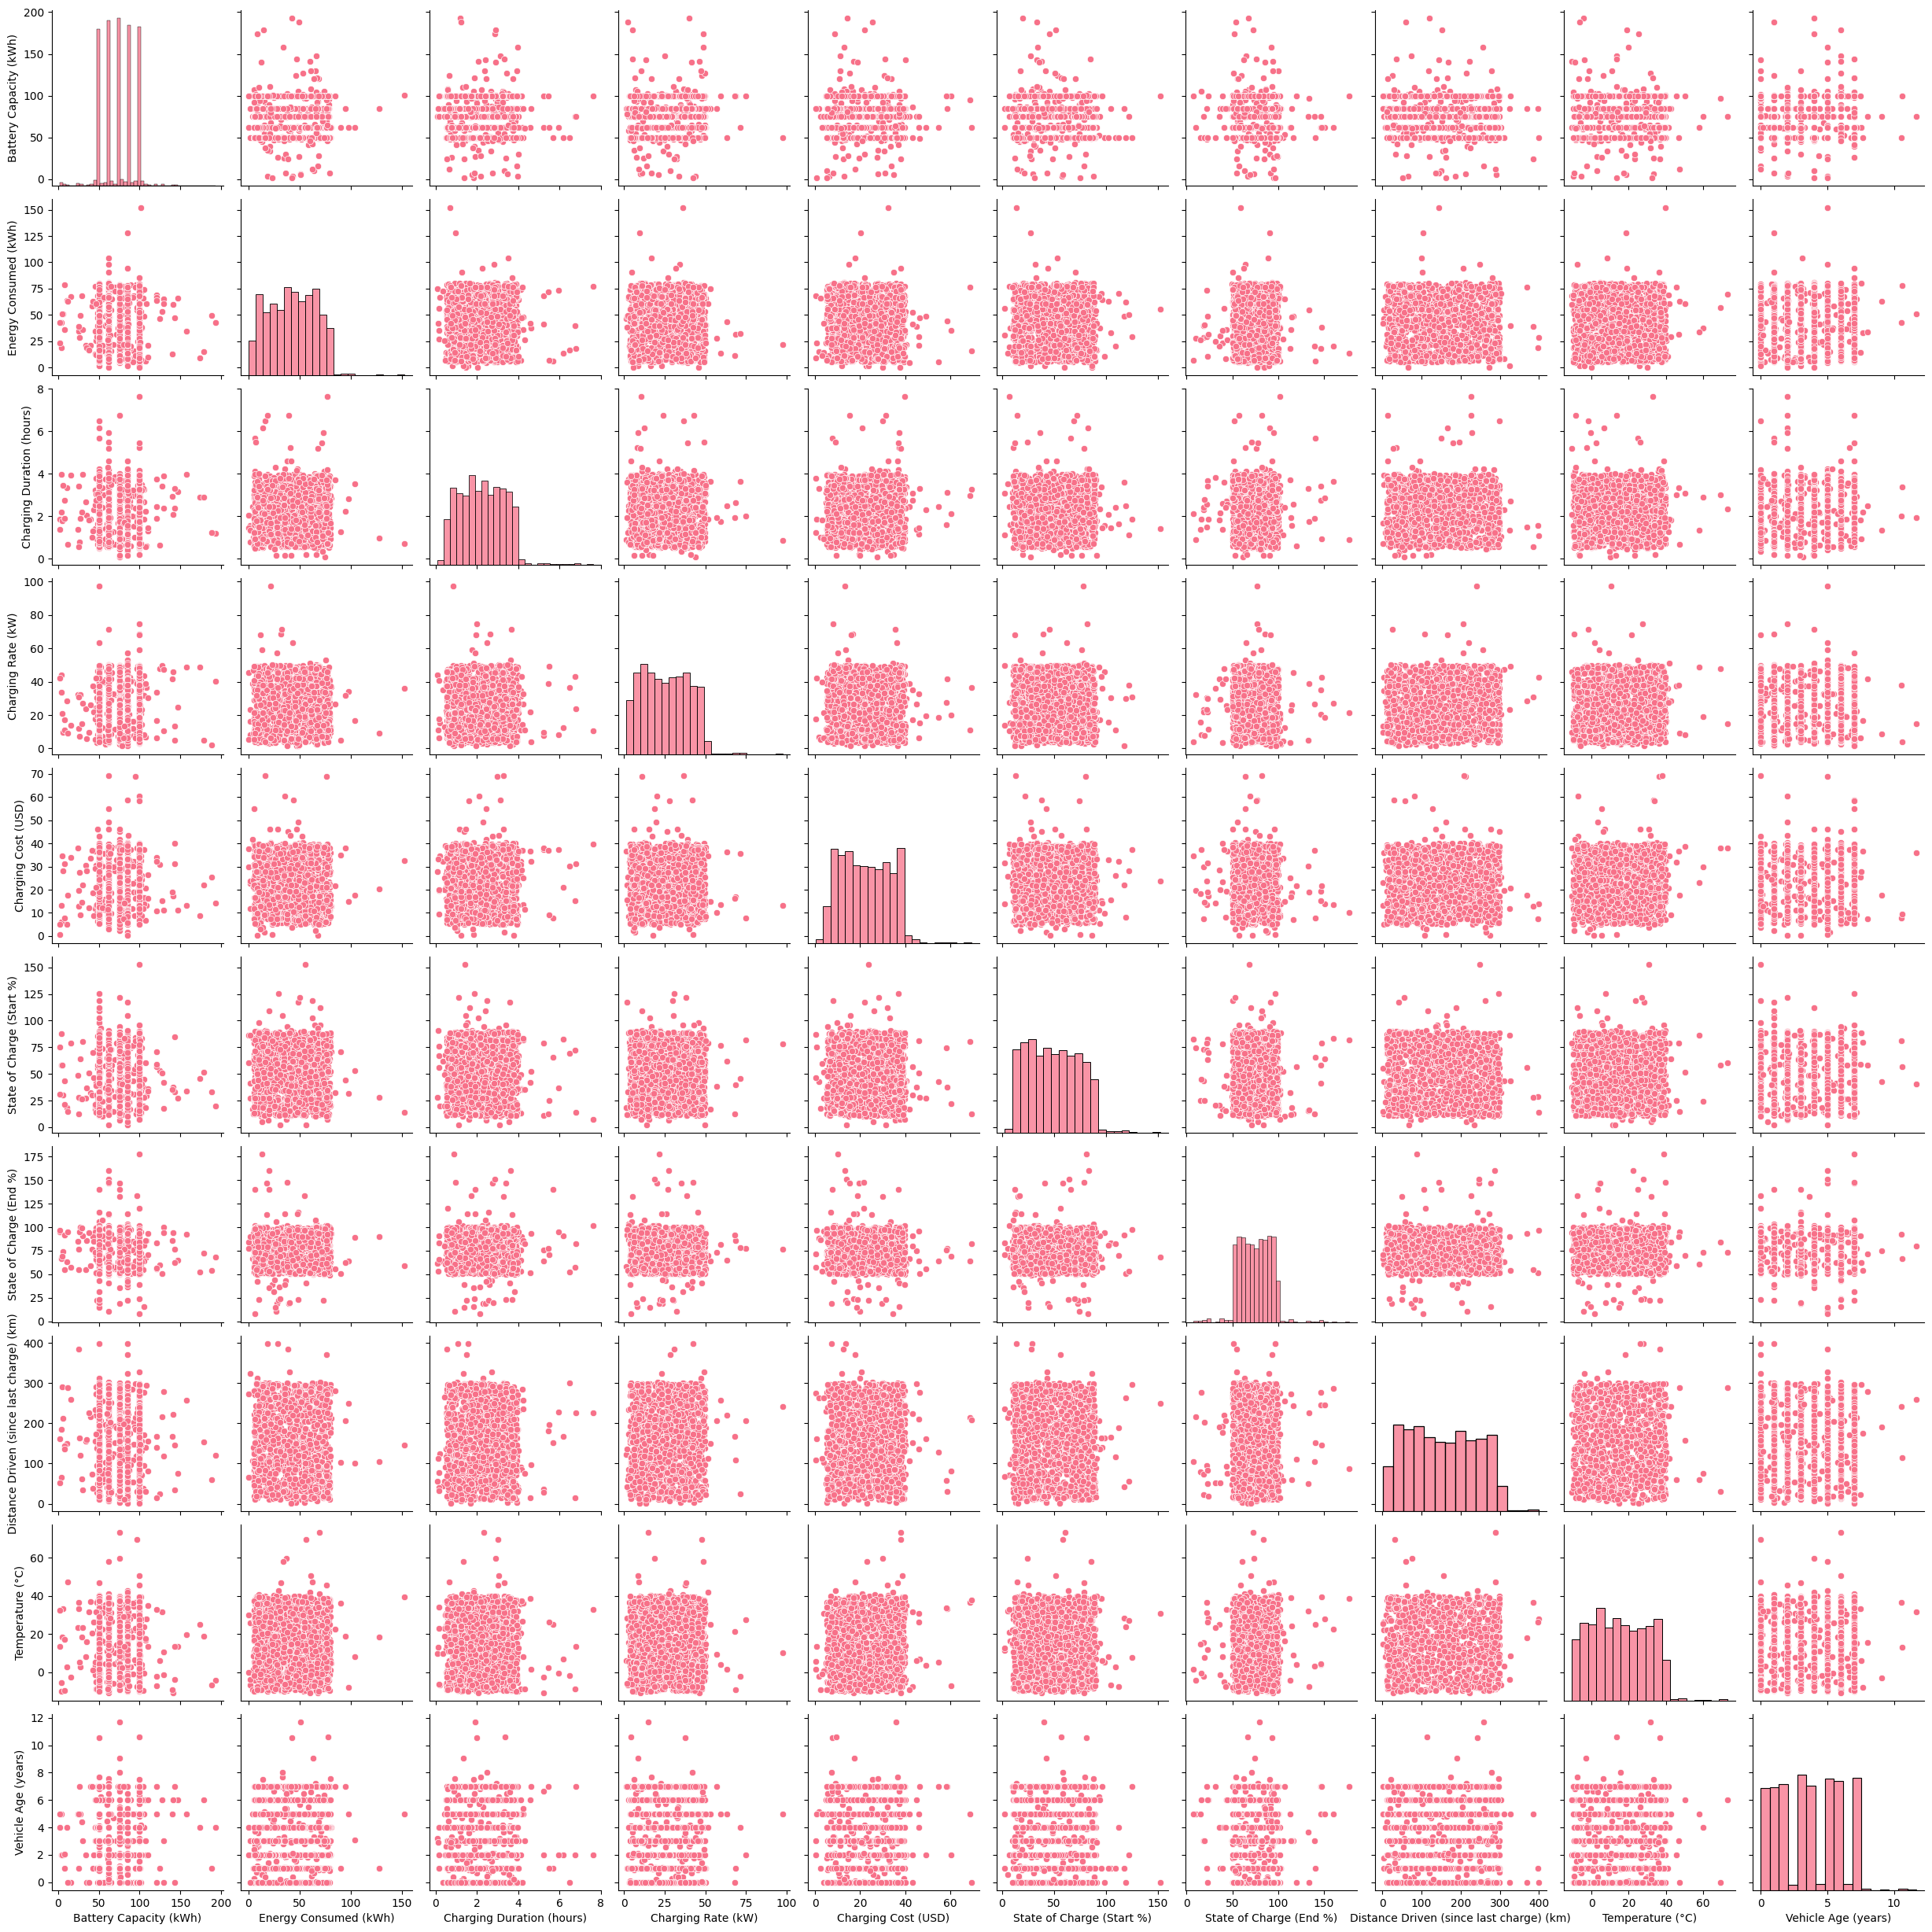

<Figure size 5000x4000 with 0 Axes>

In [24]:
sns.set_palette('husl')
%matplotlib inline
correlation = sns.pairplot(data, diag_kind='hist')
plt.figure(figsize=(50, 40))
plt.show()

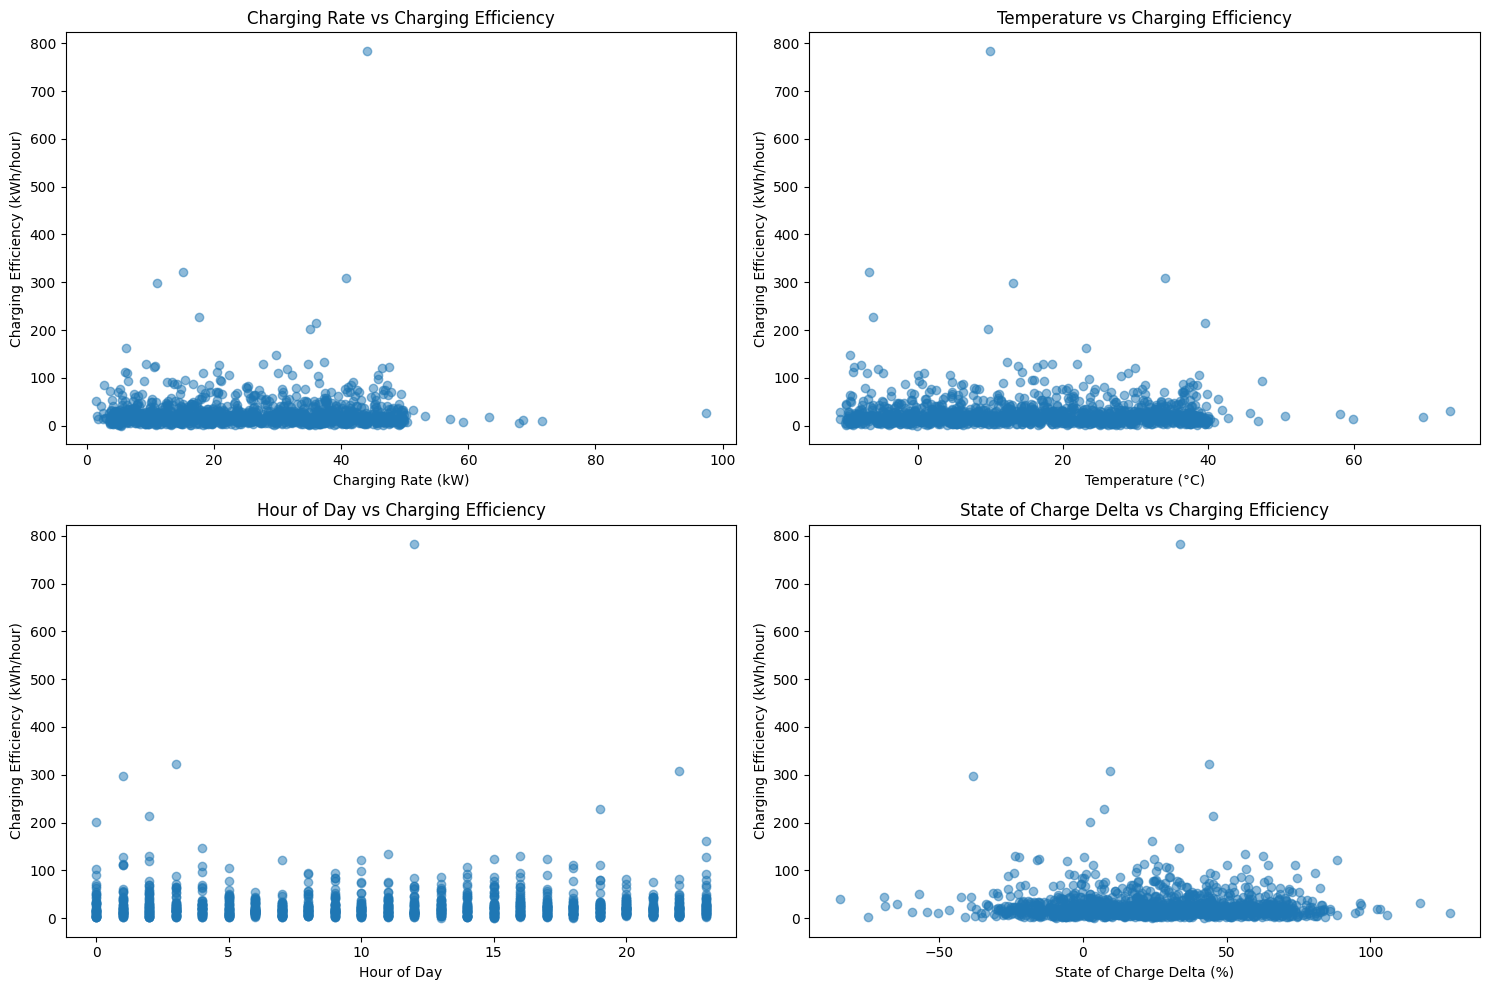

In [32]:
# Plot relationships between Charging Efficiency, State of Charge Delta, Hour of Day, Temperature, and Charging Rate
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Charging Efficiency vs. Charging Rate (kW)
axs[0, 0].scatter(data['Charging Rate (kW)'], data['Charging Efficiency (kWh/hour)'], alpha=0.5)
axs[0, 0].set_xlabel('Charging Rate (kW)')
axs[0, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 0].set_title('Charging Rate vs Charging Efficiency')

# Plot 2: Charging Efficiency vs. Temperature (°C)
axs[0, 1].scatter(data['Temperature (°C)'], data['Charging Efficiency (kWh/hour)'], alpha=0.5)
axs[0, 1].set_xlabel('Temperature (°C)')
axs[0, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[0, 1].set_title('Temperature vs Charging Efficiency')

# Plot 3: Charging Efficiency vs. Hour of Day
axs[1, 0].scatter(data['Hour of Day'], data['Charging Efficiency (kWh/hour)'], alpha=0.5)
axs[1, 0].set_xlabel('Hour of Day')
axs[1, 0].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 0].set_title('Hour of Day vs Charging Efficiency')

# Plot 4: Charging Efficiency vs. State of Charge Delta (%)
axs[1, 1].scatter(data['State of Charge Delta (%)'], data['Charging Efficiency (kWh/hour)'], alpha=0.5)
axs[1, 1].set_xlabel('State of Charge Delta (%)')
axs[1, 1].set_ylabel('Charging Efficiency (kWh/hour)')
axs[1, 1].set_title('State of Charge Delta vs Charging Efficiency')

plt.tight_layout()
plt.show()

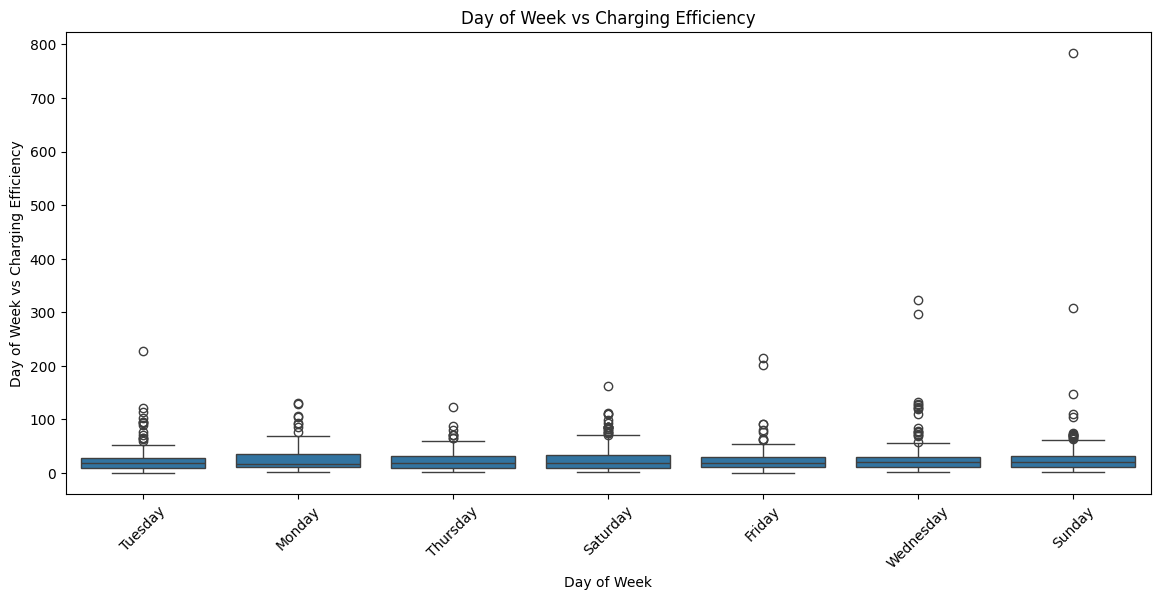

In [28]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Day of Week', y='Charging Efficiency (kWh/hour)', data=data)
plt.title('Day of Week vs Charging Efficiency')
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Day of Week vs Charging Efficiency')
plt.show()

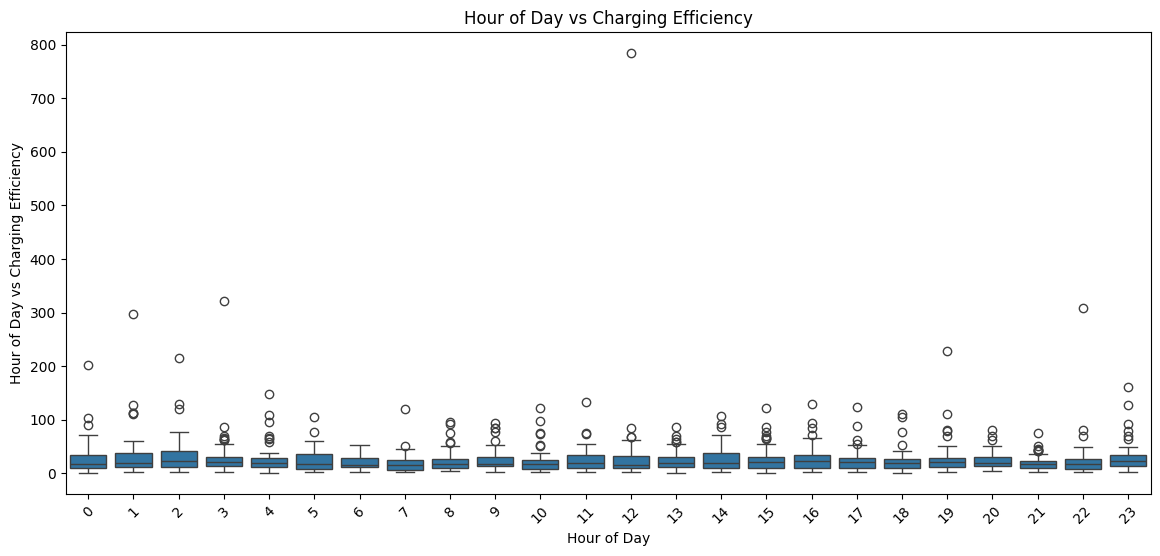

In [30]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Hour of Day', y='Charging Efficiency (kWh/hour)', data=data)
plt.title('Hour of Day vs Charging Efficiency')
plt.xticks(rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Hour of Day vs Charging Efficiency')
plt.show()